In [1]:
from google.colab import drive
drive.mount("/content/drive")
import os 
os.chdir("files_path")
!ls

Mounted at /content/drive
best_cnn_classifier_acc_58.pth	final_model_cifar10.pth
best_cnn_classifier.pth		mini-imagenet-cache-dataset.pkl
best_cnn_miniImagenet.pth	__pycache__
CNN_Cifar10.ipynb		TransferLearning.ipynb
CNN_miniImagenet.ipynb		utils.py
data


In [2]:
import torch
import torchvision
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
import pickle
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
plt.style.use(['dark_background'])
import matplotlib as mpl
mpl.style.use('seaborn')
from utils import  split_dataset, MiniImageNetDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
data_file = open("mini-imagenet-cache-dataset.pkl", "rb")
data = pickle.load(data_file)

In [4]:
transform = transforms.Compose([
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
dataset = MiniImageNetDataset(data, transform)

In [5]:
train_set, val_set, test_set = split_dataset(dataset)
train_loader = DataLoader(dataset=train_set, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_set, batch_size=32)
test_loader = DataLoader(dataset=test_set, batch_size=32)

In [21]:
class CNN_Model(nn.Module):

    def __init__(self, input_channels, num_classes):
        super(CNN_Model, self).__init__()

        # 3x64x64
        self.conv1 = nn.Sequential(
                nn.Conv2d(in_channels=input_channels, out_channels=16, 
                            kernel_size=(3, 3), stride=(1, 1), padding=1),
                nn.BatchNorm2d(16),
                nn.ReLU()
                # nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
                )
        # 16x64x64
        self.conv2 = nn.Sequential(
                nn.Conv2d(in_channels=16, out_channels=32, 
                            kernel_size=(3, 3), stride=(1, 1), padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))              
                )
        # 32x32x32
        self.conv3 = nn.Sequential(
                nn.Conv2d(in_channels=32, out_channels=32, 
                            kernel_size=(3, 3), stride=(1, 1), padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU()
                # nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
                )
        # 32x32x32
        self.conv4 = nn.Sequential(
                nn.Conv2d(in_channels=32, out_channels=64, 
                            kernel_size=(3, 3), stride=(1, 1), padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
                )
        # 64x16x16
        self.conv5 = nn.Sequential(
                nn.Conv2d(in_channels=64, out_channels=64, 
                            kernel_size=(3, 3), stride=(1, 1), padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU()
                # nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
                )
        # 64x16x16
        self.fc1 = nn.Sequential(
                nn.Linear(64*16*16, 2048),
                nn.ReLU(),
                nn.Dropout(0.5)
        )
        self.fc2 = nn.Sequential(
                nn.Linear(2048, 512),
                nn.ReLU(),
                nn.Dropout(0.5)
        )
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(-1, 64*16*16) # flatten output of conv layer for fc layer.
        out = self.fc1(out)
        out = self.fc2(out) 
        out = self.fc3(out) 

        return out 

In [22]:
def evaluation(model, val_loader, criterion):
    
    model.eval()
    loss = 0
    correct = 0
    total = 0
    num_batches = len(val_loader)
    for images, labels in val_loader:
        labels = labels.to(device)
        outputs = model(images.to(device))
        loss += criterion(outputs, labels.to(device))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return (correct / total), loss / num_batches 

In [56]:
def train_model(model, train_loader, criterion, optimizer, val_loader, lr_schduler, num_epochs=10):
    
    model.train()
    loss_hist_tr = [] # per iterations
    acc_hist_tr = []
    loss_hist_vl = [] # per iterations
    acc_hist_vl = []
    best_val_acc = 0.50
    num_batches = len(train_loader)
    for epoch in range(num_epochs):
        epoch_acc = 0
        epoch_loss = 0
        for itr, (images, labels) in enumerate(train_loader):
            # Forward pass
            outputs = model(images.to(device))
            loss = criterion(outputs, labels.to(device))
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_hist_tr.append(loss.item())
            epoch_loss += loss.item() 

            _, predicted = torch.max(outputs.detach().cpu(), dim=1)
            correct = (predicted == labels).sum().item()
            accuracy = correct / len(labels)
            acc_hist_tr.append(accuracy)
            epoch_acc += accuracy
            if (itr + 1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Iteration [{itr + 1}/{num_batches}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2%}')

            with torch.no_grad():
                val_accuracy, val_loss = evaluation(model, val_loader, criterion)
                loss_hist_vl.append(val_loss.item())
                acc_hist_vl.append(val_accuracy)
                if (val_accuracy > best_val_acc):
                        torch.save(model.state_dict(), 'best_cnn_miniImagenet.pth')
                        best_val_acc = val_accuracy

            if (itr + 1) % 200 == 0:
                    print(f'Validate model on the 800 validation images: Loss= {val_loss.item():.4f}, Accuracy= {val_accuracy:.2%}')

        print(f'{"="*25}\nEnd of Epoch {epoch + 1},  Mean_Loss= {epoch_loss / num_batches:.4f}, Mean_Acc= {epoch_acc / num_batches:.2%}\n{"="*25}')
        lr_schduler.step()

    return model, loss_hist_tr, acc_hist_tr, loss_hist_vl, acc_hist_vl 

## Transfer Learning
    Train 'CNN_Model' on Cifar10.
    Use pretrained model for Fine-tuning on miniImagenet 

In [24]:
transform = transforms.Compose(
    [transforms.Resize(64, interpolation=3),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50,
                                          shuffle=True, num_workers=2)


Files already downloaded and verified


In [29]:
def train():
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # forward + backward + optimize
            outputs = model(inputs.to(device)).to(device)
            loss = criterion(outputs, labels.to(device))
            # zero the parameter gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:    # print every 100 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0

    print('Finished Training')

In [30]:
input_channels = 3
num_classes = 10
num_epochs = 25
learning_rate = 0.001
momentum = 0.9

In [31]:
model = CNN_Model(input_channels, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
train()
torch.save(model.state_dict(), 'pretrained_model.pth')

[1,   100] loss: 2.184
[1,   200] loss: 1.846
[1,   300] loss: 1.669
[1,   400] loss: 1.567
[1,   500] loss: 1.500
[1,   600] loss: 1.450
[1,   700] loss: 1.386
[1,   800] loss: 1.384
[1,   900] loss: 1.368
[1,  1000] loss: 1.301
[2,   100] loss: 1.222
[2,   200] loss: 1.219
[2,   300] loss: 1.180
[2,   400] loss: 1.163
[2,   500] loss: 1.144
[2,   600] loss: 1.142
[2,   700] loss: 1.099
[2,   800] loss: 1.086
[2,   900] loss: 1.089
[2,  1000] loss: 1.037
[3,   100] loss: 1.000
[3,   200] loss: 0.979
[3,   300] loss: 0.971
[3,   400] loss: 0.954
[3,   500] loss: 0.957
[3,   600] loss: 0.922
[3,   700] loss: 0.922
[3,   800] loss: 0.898
[3,   900] loss: 0.891
[3,  1000] loss: 0.897
[4,   100] loss: 0.837
[4,   200] loss: 0.833
[4,   300] loss: 0.810
[4,   400] loss: 0.817
[4,   500] loss: 0.804
[4,   600] loss: 0.810
[4,   700] loss: 0.800
[4,   800] loss: 0.813
[4,   900] loss: 0.787
[4,  1000] loss: 0.784
[5,   100] loss: 0.733
[5,   200] loss: 0.734
[5,   300] loss: 0.708
[5,   400] 

In [69]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=50,
                                         shuffle=False, num_workers=2)
test_model = CNN_Model(input_channels, num_classes=10).to(device)
test_model.load_state_dict(torch.load('pretrained_model.pth'))
test_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = test_model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Files already downloaded and verified
Accuracy of the network on the 10000 test images: 80 %


In [70]:
input_size = 84 #(84x84)
input_channels = 3
num_classes = 16
num_epochs = 5
learning_rate = 0.001
weight_decay= 0.0001
pretrained = CNN_Model(input_channels, num_classes=10)
pretrained.load_state_dict(torch.load('pretrained_model.pth'))
pretrained.fc3 = nn.Linear(512, num_classes)
# print(pretrained.state_dict())

In [ ]:
model = CNN_Model(input_channels, num_classes).to(device)
model.load_state_dict(pretrained.state_dict())
for name, childe in model.named_children():
    # print(name, module)
    if 'conv1' in name or 'fc1' in name:
        # print(name)
        for p in childe.parameters():
            p.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_scheduler = StepLR(optimizer, step_size=2, gamma=0.5)

model, loss_hist_tr, acc_hist_tr, loss_hist_vl, acc_hist_vl =\
     train_model(model, train_loader, criterion, optimizer, val_loader, lr_scheduler, num_epochs=num_epochs)

Epoch [1/5], Iteration [100/375], Loss: 1.7755, Accuracy: 51.56%
Epoch [1/5], Iteration [200/375], Loss: 1.4973, Accuracy: 53.91%
Validate model on the 800 validation images: Loss= 1.4121, Accuracy= 54.50%


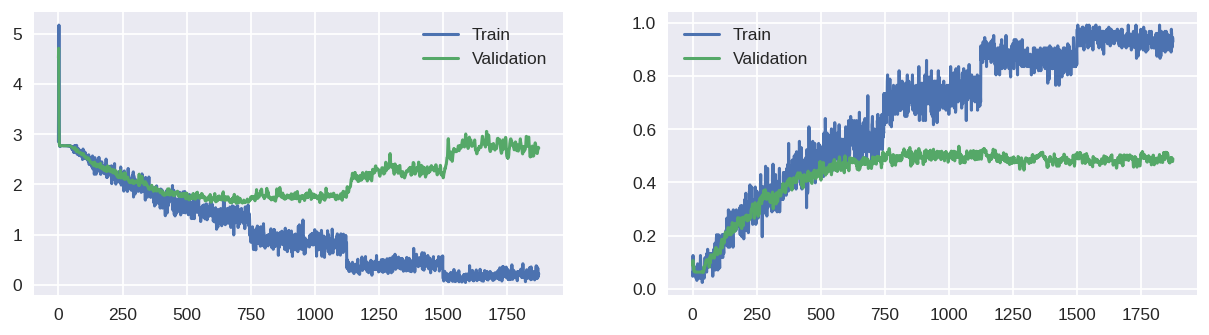

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3), dpi=125)
ax1.plot(loss_hist_tr, label='Train')
ax1.plot(loss_hist_vl, label='Validation')
ax1.legend()
ax2.plot(acc_hist_tr, label='Train')
ax2.plot(acc_hist_vl, label='Validation')
ax2.legend()

In [59]:
# torch.save(model.state_dict(), 'final_cnn_classifier.pth')
model.eval()

correct = 0
total = 0
for images, labels in test_loader:

    outputs = model(images.to(device)).detach().cpu()
    # print(f'outputs: {outputs.shape}')
    _, predicted = torch.max(outputs, dim=1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 800 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 800 test images: 49.625 %


In [61]:
model_test = CNN_Model(input_channels, num_classes).to(device)
# model_test.load_state_dict(pretrained.state_dict())
model_test.load_state_dict(torch.load('best_cnn_miniImagenet.pth'))

<All keys matched successfully>

In [62]:
model_test.eval()
correct = 0
total = 0
for images, labels in test_loader:
    # labels = labels.to(device)
    outputs = model_test(images.to(device)).detach().cpu()
    # print(f'outputs: {outputs.shape}')
    _, predicted = torch.max(outputs, dim=1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 800 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 800 test images: 51.75 %
